## Imports Useful Libraries

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import time
from datetime import timedelta

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from mnist import MNIST
data = MNIST(data_dir="data/MNIST/")

## Copy some of the data-dimensions for convenience.
img_size_flat is the number of pixels in an image when the image is flattened, img_size_flat = 28 * 28 = 784.

img_shape is the shape of an image in 2-D, img_shape = 28 * 28 (28 by 28).

num_classes is the number of output classes for the images, num_classes = 10

In [3]:
img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes

## Define the placeholders for feeding the training and testing data to the computational graph
x is a placeholder variable whose dimensions are [None, img_size_flat] through which the images are fed to the model for training as well as testing.

y_true is the placeholder through which the correct class for a training or testing data is fed to the network.

In [4]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes]) # y_true is a one-hot vector of class labels
y_true_cls = tf.argmax(y_true, axis =1) # not a placeholder, y_true cls contains the class label as an integral value

## Define the dimensions of the model
Our model is a multi-layer perceptron with 4 hidden layers having 1000, 1000, 500 and 200 neurons respectively. For ease of simplicity, biases are not used in the model.

In [5]:
hidden1 = 1000
hidden2 = 1000
hidden3 = 500
hidden4 = 200

## Variables to be optimized
w1-w5 are 5 trainable variables that will be optimized during the training.

In [6]:
w1 = tf.Variable(tf.truncated_normal([img_size_flat,hidden1], stddev = 0.05, seed=25))
h1 = tf.nn.relu(tf.matmul(x,w1))

w2 = tf.Variable(tf.truncated_normal([hidden1,hidden2],stddev = 0.05, seed=25))
h2 = tf.nn.relu(tf.matmul(h1,w2))

w3 = tf.Variable(tf.truncated_normal([hidden2,hidden3], stddev = 0.05, seed=25))
h3 = tf.nn.relu(tf.matmul(h2,w3))

w4 = tf.Variable(tf.truncated_normal([hidden3,hidden4],stddev = 0.05, seed=25))
h4 = tf.nn.relu(tf.matmul(h3,w4))

w5 = tf.Variable(tf.truncated_normal([hidden4,num_classes], stddev = 0.05, seed=25))
logits = tf.matmul(h4,w5)

y_pred = tf.nn.softmax(logits)

y_pred_cls = tf.argmax(y_pred, axis=1)

## Calculation of model loss
To understand and quantify the performance of the model, a cross-entropy loss is defined over the oputput of the model and true class values.

In [7]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

## Define optimization and accuracy operation

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create a tensorflow session and initialize all the variables

In [9]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [10]:
batch_size = 100

## Define a function for carrying out iterations to train the model

In [11]:
def optimize(optimizer, num_iterations):
        
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        feed_dict_train = {x: x_batch,y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [12]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

## Define a function to calculate and print the accuracy over the test set

In [13]:
def print_accuracy():
    
    start_time = time.time()
    
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
    end_time = time.time()
    
    timedelta = (end_time-start_time)*1000
    print("Execution time in milliseconds: {0:.4}".format(timedelta))
    
    return acc, timedelta

## Performance after 2000 optimization iterations

In [14]:
optimize(optimizer, num_iterations=2000)

In [15]:
original_accuracy = session.run(accuracy, feed_dict = feed_dict_test)
print("Accuracy on test-set: {0:.1%}".format(original_accuracy))

Accuracy on test-set: 97.3%


# Recovery analysis when the neuron pruned network is trained again
When a neuron pruned network is trained again for 500 iterations, it is able to recover almost completely unitl the sparsity is upto 90%, however once the sparsity becomes higher than 90%, it is not able to recover (it may or may not recover when more iterations are performed).

In [16]:
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [17]:
def retrain_neuron_pruning(sparsity,num_iterations):

    acc_after_retraining = []
    acc_before_retraining = []
    
    for k in sparsity:
    
        # Convert the weights of the trained model to numpy arrays for pre-processing.
        wt1 = np.asarray(session.run(w1))
        wt2 = np.asarray(session.run(w2))
        wt3 = np.asarray(session.run(w3))
        wt4 = np.asarray(session.run(w4))
        wt5 = np.asarray(session.run(w5))
        
        # Find the norm of each column (each column corresponds to a neuron in the next layer) in each weight matrix.
        norm1 = LA.norm(wt1, axis=0)
        norm2 = LA.norm(wt2, axis=0)
        norm3 = LA.norm(wt3, axis=0)
        norm4 = LA.norm(wt4, axis=0)
        
        # Set the weights for lower k% norms to 0. This renders k% neurons in each hidden layer passive.
        # The connections from last hidden layer to the output layer have been left as it is.
        wt1[:,np.argwhere(norm1<np.percentile(norm1,k))] = 0
        wt2[:,np.argwhere(norm2<np.percentile(norm2,k))] = 0
        wt3[:,np.argwhere(norm3<np.percentile(norm3,k))] = 0
        wt4[:,np.argwhere(norm4<np.percentile(norm4,k))] = 0
    
        # Define the architecture of the neural network
        wt1 = tf.Variable(tf.convert_to_tensor(wt1.reshape([img_size_flat,hidden1])))
        ht1 = tf.nn.relu(tf.matmul(x,wt1))

        wt2 = tf.Variable(tf.convert_to_tensor(wt2.reshape([hidden1,hidden2])))
        ht2 = tf.nn.relu(tf.matmul(ht1,wt2))

        wt3 = tf.Variable(tf.convert_to_tensor(wt3.reshape([hidden2,hidden3])))
        ht3 = tf.nn.relu(tf.matmul(ht2,wt3))

        wt4 = tf.Variable(tf.convert_to_tensor(wt4.reshape([hidden3,hidden4])))
        ht4 = tf.nn.relu(tf.matmul(ht3,wt4))

        wt5 = tf.Variable(tf.convert_to_tensor(wt5))
        logits = tf.matmul(ht4,wt5)
        
        # Now, we calculate accuracy of the model in two ways:
        
        # i) Inducing sparsity by setting connections of k% neurons in each layer to 0(except last hidden layer 
        # neurons) and calculating accuracy before retraining the network
        
        # ii) Inducing sparsity by setting connections of k% neurons in each layer to 0(except last hidden layer 
        # neurons) and calculating accuracy after retraining the network
        
        # It must be noted that the number of neurons in each layer has remained same in both the cases. Howevwer, 
        # k% neurons in each layer have been rendered passive
        
        y_pred = tf.nn.softmax(logits)
        y_pred_cls = tf.argmax(y_pred, axis=1)
        
        # Define operation to calculate accuracy before retraining
        correct_prediction_before_retraining = tf.equal(y_pred_cls, y_true_cls)
        accuracy_before_retraining = tf.reduce_mean(tf.cast(correct_prediction_before_retraining, tf.float32))
        
        # Find the cross entropy and loss
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y_true)
        cost = tf.reduce_mean(cross_entropy)
            
        # Define optimization operation to train the network
        optimizer_np = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)
        
        # Define operation to calculate accuracy after retraining
        correct_prediction_after_retraining = tf.equal(y_pred_cls, y_true_cls)
        accuracy_after_retraining = tf.reduce_mean(tf.cast(correct_prediction_after_retraining, tf.float32))
        
        # Initialize the trainable variables
        session.run(wt1.initializer)
        session.run(wt2.initializer)
        session.run(wt3.initializer)
        session.run(wt4.initializer)
        session.run(wt5.initializer)
        
        # Calculate accuracy before retraining
        acc1 = session.run(accuracy_before_retraining, feed_dict = feed_dict_test)
        acc_before_retraining.append(acc1*100)
        
        # Retrain the network by running optimize function defined above
        optimize(optimizer_np, num_iterations)
        
        # Calculate accuracy before retraining
        acc2 = session.run(accuracy_after_retraining, feed_dict = feed_dict_test)
        acc_after_retraining.append(acc2*100)
        
    
    return acc_before_retraining, acc_after_retraining
    
    #####################################################################################################
    
    

In [18]:
acc_before_retraining, acc_after_retraining = retrain_neuron_pruning(sparsity,1000)

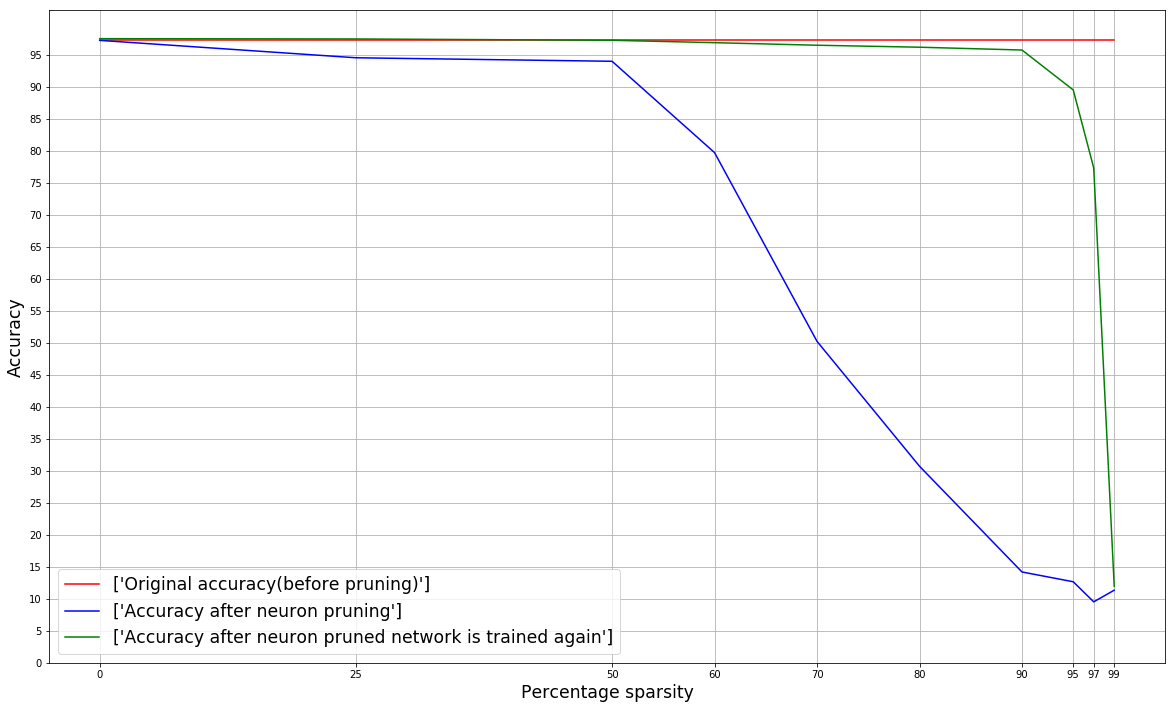

In [20]:
rcParams['figure.figsize'] = 20, 12
plt.plot(sparsity,np.size(sparsity)*[original_accuracy*100],'r',
         sparsity,acc_before_retraining,'b',
         sparsity,acc_after_retraining,'g')

plt.grid()

plt.legend([['Original accuracy(before pruning)'],
            ['Accuracy after neuron pruning'],
            ['Accuracy after neuron pruned network is trained again']],
           loc='lower left', fontsize='xx-large')

plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Accuracy',fontsize='xx-large')

plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))

plt.show()

# Important
As we increase the number of iterations to retrain the neuron pruned network, it keeps on recovering its accuracy. Initially, I trained it for 500 iterations and the network was able to recover till 80% sparsity. The results above are for 1000 iterations and the network is able to recover till 95% sparsity. To the best of my understanding, as we retrain it over more iterations, it should recover completely till 99% sparsity.